# 1. Introduction

## 1.1 Quick Summary
### Insider trading
Insider trading involves the buying or selling of a public company's stock by individuals who have access to non-public, material information about the company. Legal insider trading is regulated and must be disclosed publicly, while illegal insider trading involves trading based on confidential information that gives an unfair advantage. The distinction between legal and illegal insider trading is defined under Section 16 of the Securities Exchange Act, which mandates insiders to publicly disclose their trades.
### Why should insider trading play a role when making investment decisions?
Insider trading can provide valuable insights into the future prospects of a company. When insiders, such as executives and directors, buy or sell shares, it often signals their confidence or concerns about the company's performance. Tracking these trades can help investors make more informed decisions.

## 1.2 Research Goals
### Which insights does insider trading give us in terms of stock behavior?
Insider trading activity can indicate potential stock price movements. For example, significant insider purchases may suggest that the insiders believe the stock is undervalued and poised for growth, while large sales might indicate potential issues or overvaluation. Analyzing historical insider transactions, such as those foreshadowing the tech sell-off in 2022, can reveal patterns that might predict future market behaviors.
### How does the methodological knowledge of the lecture help us in getting to these insights?
The methodological knowledge from the lecture, such as statistical analysis, machine learning, and financial modeling, allows us to systematically analyze insider trading patterns. By applying these techniques, we can identify trends, correlations, and anomalies in insider trading data that can be leveraged for predictive insights.

## 1.3 Data Sources
### What is the SEC API?
The SEC API (Securities and Exchange Commission Application Programming Interface) provides access to a wealth of financial data, including insider trading reports. It allows users to retrieve information about insider transactions, company filings, and other regulatory disclosures in a structured and automated manner. The SEC API facilitates the extraction of data from the SEC EDGAR (Electronic Data Gathering, Analysis, and Retrieval) database, enabling detailed analysis of insider trading activities.
### Overview of our data source
Our primary data source is the SEC EDGAR database, accessed through the SEC API. This database contains detailed records of insider trading activities reported on Forms 3, 4, and 5.

**Form 3**: This form is filed when an individual becomes an insider, such as when they are appointed as a director or officer of the company or when they acquire a significant ownership stake (typically more than 10%). It provides an initial statement of ownership.

**Form 4**: This form must be filed whenever there is a change in an insider's ownership position. It discloses transactions such as purchases, sales, and transfers of the company's stock. Form 4 must be filed within two business days following the transaction, ensuring timely disclosure.

**Form 5**: This form is an annual summary of insider transactions that were not reported earlier on Forms 3 or 4. It includes any previously unreported transactions from the past fiscal year and is due within 45 days after the end of the company's fiscal year.
### Regulatory Mechanisms to Exclude Signals in Insider Trades
Section 16(b) of the Securities Exchange Act, also known as the "short-swing profit rule," plays a critical role in regulating insider trading. This rule is designed to prevent insiders—such as directors, officers, and significant shareholders (owning more than 10% of a company's shares)—from profiting from short-term trades. Specifically, if an insider buys and sells, or sells and buys, company stock within a six-month period, any profit made must be returned to the company. This regulation aims to discourage insiders from using their privileged information for quick financial gains.

To address the challenge of insiders having constant access to material nonpublic information, Section 10b5-1 of the Securities Exchange Act provides a legal framework. Insiders can adopt a written trading plan specifying the amount, price, and dates of future trades. If the plan is established before the insider becomes aware of any material nonpublic information and trades are executed according to the plan, the insider is protected from allegations of insider trading.
These plans must be disclosed, often through voluntary filings under Item 8.01 of Form 8-K. Although not mandatory, this disclosure adds another layer of transparency.

Rule 10b5-1 is crucial because it aims to prevent insiders from exploiting nonpublic information for personal gain while allowing them to trade their shares lawfully. However, studies have shown that some insiders can still time the market advantageously within the boundaries of these plans, indicating that insider transactions may still carry predictive signals regarding future stock performance. For example, Elon Musk's sales of Tesla shares in late 2021 coincided with the peak of Tesla's share price, suggesting that even regulated insider transactions can provide valuable market signals. Similarly, Berkshire Hathaway's strategic purchases of Occidental Petroleum (OXY) shares in 2022, which were timed during market dips, highlight how well-timed insider trades can still offer insights into the company’s future performance.

# 2. Data Collection and Processing

## 2.1 Imports

In [1]:
from sec_api import InsiderTradingApi
import pandas as pd
from pydash import get, flatten
import warnings
import json
import math
from datetime import datetime
import ast
import os
import scipy.stats as stats
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.dates as mdates
import matplotlib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils._testing import set_random_state
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import logging

warnings.filterwarnings("ignore")

## 2.2 Data Extraction
Insider data has been created with the help of the script called "get_insiderdata_secapi.py" created by us. The script takes more than 15 hours to complete, thats why we didn't include it in our Jupyter Notebook.

THe result is a dataset of with a total of more than 4,000,000 rows, which we will use for our analysis. We narrowed the timeframe down to 01-01-2012 to 31-12-2023 because the SEC API doesn't allow for much data before that date.

The data was requested in batches of 50 (highest batch amount per request) and after that flattened and put into a csv file. We print the first five entries to ensure our data was loaded correctly.

In [2]:
df = pd.read_csv("insider_trades.csv", low_memory=False)
df.head(5)

,periodOfReport,issuerCik,issuerTicker,reportingPersonName,reportingPersonCik,relationship,type,securityTitle,codingCode,acquiredDisposed,shares,sharePrice,total,sharesOwnedFollowingTransaction,underlyingSecurity
0,2022-12-29,1673772,RAPT,HO WILLIAM,1400901,"{'isDirector': False, 'isOfficer': True, 'offi...",nonDerivative,Common Stock,S,D,5000.0,18.03,90150,37650.0,NaN
1,2022-12-30,13156,GLXZ,Waters Bryan W.,1638734,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,6122.0,2.44,14938,550648.0,NaN
2,2022-12-30,13156,GLXZ,LIPPARELLI MARK A,1207741,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,8163.0,2.44,19918,1943648.0,NaN
3,2022-12-30,13156,GLXZ,Kondra Cheryl,1899993,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,7143.0,2.44,17429,100557.0,NaN
4,2022-12-30,13156,GLXZ,Isaacs Michael Gavin,1373193,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,6122.0,2.44,14938,269919.0,NaN


We exclude the columns reportingPersonName and reportingPersonCik from our analysis since they do not contribute significantly to our insights.

In [3]:
df_len_0 = len(df)

print(f"Total number of entries before mapping stock prices: {df_len_0}")

Total number of entries before mapping stock prices: 4317587


### Get the stock market data
We retrieve the closing prices for each transaction using Algoseek to enrich our dataset with historical stock prices. The process involves defining a function to fetch the stock prices, iterating through our DataFrame to get the required prices, and updating the DataFrame accordingly. The prices from Algoseek have been retrieved by the department. We have mapped the prices for each stock and the according date.

The code will be skipped if the file "processed_stock_data.csv" exists. If not, remapping will occur (which will take about 24h) and the file will be recreated.

In [4]:
def get_stock_price(ticker, date, days_after=0):
    if pd.isna(date) or date is None or date.year < 1900:
        return 0
    
    try:
        with open(f"/home/jovyan/work/shared-for-all/algoseek_gk/algoseek/{ticker}/_closing-prices.json", 'r') as file:
            data = json.load(file)
        df = pd.DataFrame.from_dict(data, orient='index')
        df.index = pd.to_datetime(df.index.str.split('-').str[1], format='%Y%m%d')
        df = df.sort_index()
        
        target_date = date + timedelta(days=days_after)
        closest_date = df.index[df.index <= target_date].max()
        
        if pd.isna(closest_date):
            return 0
        
        return float(df.loc[closest_date, 'adjClosePrice'])
    except FileNotFoundError:
        return 0
    except Exception as e:
        return 0

def safe_to_datetime(date_str):
    try:
        dt = pd.to_datetime(date_str)
        if dt.year < 1900:
            return pd.NaT
        return dt
    except:
        return pd.NaT

def process_data(df):
    total_entries = len(df)
    print(f"Total entries to process: {total_entries}")

    for days in [0, 1, 7, 30, 90, 360]:
        column_name = f"sharePrice{days}"
        
        def process_row(row, index):
            if index % 5000 == 0:
                print(f"Processed {index} out of {total_entries} entries for {column_name}")
            return get_stock_price(
                row['issuerTicker'],
                safe_to_datetime(row['periodOfReport']),
                days
            )
        
        df[column_name] = df.apply(
            lambda row: process_row(row, row.name),
            axis=1
        )
        
        print(f"Completed processing for {column_name}")

    print("All processing completed")
    return df

# File path for the CSV
csv_file_path = 'processed_stock_data.csv'

# Check if the CSV file already exists
if os.path.exists(csv_file_path):
    print(f"Processed data found at {csv_file_path}. Loading data from CSV...")
    df = pd.read_csv(csv_file_path)
    print("Data loaded successfully.")
else:
    print("No processed data found. Starting data processing...")
    df = process_data(df)
    
    # Save the processed data to CSV
    df.to_csv(csv_file_path, index=False)
    print(f"Processed data saved to {csv_file_path}")

df.head(5)

Processed data found at processed_stock_data.csv. Loading data from CSV...
Data loaded successfully.


,periodOfReport,issuerCik,issuerTicker,relationship,type,securityTitle,codingCode,acquiredDisposed,shares,sharePrice,total,sharesOwnedFollowingTransaction,underlyingSecurity,sharePrice0,sharePrice1,sharePrice7,sharePrice30,sharePrice90,sharePrice360
0,2022-12-29,1673772,RAPT,"{'isDirector': False, 'isOfficer': True, 'offi...",nonDerivative,Common Stock,S,D,5000.0,18.03,90150,37650.0,NaN,18.35,18.35,18.35,27.96,17.91,20.1
1,2022-12-30,13156,GLXZ,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,6122.0,2.44,14938,550648.0,NaN,0.00,0.00,0.00,0.00,0.00,0.0
2,2022-12-30,13156,GLXZ,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,8163.0,2.44,19918,1943648.0,NaN,0.00,0.00,0.00,0.00,0.00,0.0
3,2022-12-30,13156,GLXZ,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,7143.0,2.44,17429,100557.0,NaN,0.00,0.00,0.00,0.00,0.00,0.0
4,2022-12-30,13156,GLXZ,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,A,A,6122.0,2.44,14938,269919.0,NaN,0.00,0.00,0.00,0.00,0.00,0.0


## 2.3 Data Cleaning
Filtering our data is a crucial step in the data preparation and analysis process for several reasons:

We do not want to use some kind of data which has faulty or missing values. Also we might need to transform some data in order to make it more useful. One example of this could be to transform features to only have "true" or "false" as a value.

### Remove missing data

We remove all rows where the share price at day 0, 1 day after, 7 days after, 30 days after, 90 days after, and 360 days after is 0.

In [5]:
df = df[(df["sharePrice0"] != 0) | (df["sharePrice1"] != 0) | (df["sharePrice7"] != 0) | (df["sharePrice30"] != 0) | (df["sharePrice90"] != 0) | (df["sharePrice360"] != 0)]

df_len_1 = len(df)

print(f"Total number of entries after adjusting for no price given: {df_len_1} ({(df_len_1 - df_len_0) / df_len_1})% of rows removed)")

Total number of entries after adjusting for no price given: 3455051 (-0.24964494011810534)% of rows removed)


## 2.4 Feature Engineering

### Creating new features
We calculate the percentage of the total amount of stocks that have been sold or bought by the insider. Following this, we remove any unnecessary entries from the dataset.

In [6]:
# Calculation of the delta of the position in percent
df["positionDelta"] = (df["sharesOwnedFollowingTransaction"] - df["shares"]) / df["sharesOwnedFollowingTransaction"] * 100

# drop "shares" and "sharesOwnedFollowingTransaction"
df = df.drop(columns=["shares", "sharesOwnedFollowingTransaction"])

issuer_df = df[['issuerCik', 'issuerTicker']]
issuer_df['key'] = range(len(issuer_df))

df.head(10)

,periodOfReport,issuerCik,issuerTicker,relationship,type,securityTitle,codingCode,acquiredDisposed,sharePrice,total,underlyingSecurity,sharePrice0,sharePrice1,sharePrice7,sharePrice30,sharePrice90,sharePrice360,positionDelta
0,2022-12-29,1673772,RAPT,"{'isDirector': False, 'isOfficer': True, 'offi...",nonDerivative,Common Stock,S,D,18.03,90150,NaN,18.3500,18.3500,18.3500,27.9600,17.9100,20.1000,86.719788
6,2022-12-28,1075736,CXDO,"{'isDirector': True, 'isOfficer': True, 'offic...",derivative,Restricted Stock Units,A,A,0.00,0,Common Stock,2.1877,2.1877,2.1877,1.8142,1.9937,3.9000,0.000000
7,2022-12-28,1075736,CXDO,"{'isDirector': True, 'isOfficer': True, 'offic...",derivative,Restricted Stock Units,M,D,0.00,0,Common Stock,2.1877,2.1877,2.1877,1.8142,1.9937,3.9000,-inf
8,2022-12-28,1075736,CXDO,"{'isDirector': True, 'isOfficer': True, 'offic...",nonDerivative,Common Stock,M,A,0.00,0,NaN,2.1877,2.1877,2.1877,1.8142,1.9937,3.9000,99.776818
9,2022-12-28,1075736,CXDO,"{'isDirector': True, 'isOfficer': True, 'offic...",nonDerivative,Common Stock,F,D,1.73,13847,NaN,2.1877,2.1877,2.1877,1.8142,1.9937,3.9000,99.928495
10,2022-12-21,102037,UVV,"{'isDirector': True, 'isOfficer': True, 'offic...",nonDerivative,Common Stock,G,D,0.00,0,NaN,53.0407,53.0407,53.0407,51.2064,48.9284,60.9531,97.866340
11,2022-12-21,102037,UVV,"{'isDirector': True, 'isOfficer': True, 'offic...",nonDerivative,Common Stock,G,D,0.00,0,NaN,53.0407,53.0407,53.0407,51.2064,48.9284,60.9531,98.173735
12,2022-12-28,1621832,AQMS,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,P,A,0.75,19227,NaN,0.7609,0.7609,0.7609,1.3800,1.0400,0.8580,92.701114
13,2022-12-28,1621832,AQMS,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Common Stock,P,A,0.75,6409,NaN,0.7609,0.7609,0.7609,1.3800,1.0400,0.8580,92.703254
17,2022-12-29,1720671,HCP,"{'isDirector': True, 'isOfficer': False, 'isTe...",nonDerivative,Class A Common Stock,S,D,27.13,154479,NaN,31.7700,31.7700,31.7700,31.8300,29.6200,22.7950,75.083144


### Handling categorical data

We break up the relationship column into unique features for each relationship type. For example, if the relationship column contains "Director", "Officer", and "Other", we will create 3 new columns: "isDirector", "isOfficer", and "isOther". (Takes several minutes to get data out of relationship)

In [7]:
def str_to_dict(row):
    return ast.literal_eval(row)

if not os.path.exists('final_df.csv'):
        print("final_df.csv doesn't exist yet. Creating it (will take more than 10 minutes ...")
        
        df['relationship_dict'] = df['relationship'].apply(str_to_dict)
        relationship_df = df['relationship_dict'].apply(pd.Series)

        print("Merging new columns into the original DataFrame...")
        df = pd.concat([df, relationship_df], axis=1)

        print("Dropping the original 'relationship' column...")
        df = df.drop(['relationship', 'relationship_dict'], axis=1)
        
        df.to_csv("final_df.csv", index=False)
else:
    df = pd.read_csv("final_df.csv")
    print("final_df.csv already exists. Skipping creation...")

df['key'] = range(len(df))
df = pd.merge(df, issuer_df[['key', 'issuerCik', 'issuerTicker']], on='key', how='left')
df.drop(columns=['key'], inplace=True)

final_df.csv already exists. Skipping creation...


Creating the change in value from day 0 (date where the insider trade happened).

In [8]:
# transform for every sharePriceX add a sharePriceChangeX
df["sharePriceChange1"] = (df["sharePrice1"] - df["sharePrice0"]) / df["sharePrice0"]
df["sharePriceChange7"] = (df["sharePrice7"] - df["sharePrice0"]) / df["sharePrice0"]
df["sharePriceChange30"] = (df["sharePrice30"] - df["sharePrice0"]) / df["sharePrice0"]
df["sharePriceChange90"] = (df["sharePrice90"] - df["sharePrice0"]) / df["sharePrice0"]
df["sharePriceChange360"] = (df["sharePrice360"] - df["sharePrice0"]) / df["sharePrice0"]

Next we check what unique values the different features have to be able to handle them.

In [9]:
print(df["type"].unique())
print(df["securityTitle"].unique())
print(df["codingCode"].unique())
print(df["acquiredDisposed"].unique())
print(df["positionDelta"].unique())
print(df["isDirector"].unique())
print(df["isOfficer"].unique())
print(df["isTenPercentOwner"].unique())

['nonDerivative' 'derivative']
['Common Stock' 'Restricted Stock Units' 'Class A Common Stock' ...
 'Limited Partnership Unit Option (Right to Buy)' 'Deferral Interests'
 'Stock Option - Right to Purchase']
['S' 'A' 'M' 'F' 'G' 'P' 'C' 'J' 'D' 'X' 'L' 'W' 'H' 'I' 'E' 'U' 'O' 'Z'
 nan]
['D' 'A']
[86.71978752  0.                -inf ... 99.23680877 98.78642086
 99.33673724]
[False  True]
[ True False]
[False  True]


We remove all non numerical values from "positionDelta" and "total" and drop "inf" values from "positionDelta".

In [10]:
# Remove all non numberical values from "positionDelta"
df["positionDelta"] = pd.to_numeric(df["positionDelta"], errors="coerce")

# Drop "inf" values from "positionDelta"
df = df.dropna(subset=["positionDelta"])

# Remove all non numberical values from "total"
df["total"] = pd.to_numeric(df["total"], errors="coerce")

print(len(df))

3452331


We change the "type" feature to be binary (either true or false).

In [11]:
# in column "type" change "nonDerivative" to "True" and "derivative" to "False"
df["type"] = df["type"].apply(lambda x: True if x == "nonDerivative" else False)

Next we break up the column "acquiredDisposed" into two features: "True" and "False". Which indicates whether a row represents a purchase (True) or a sale (False).

In [12]:
# in column "acquiredDisposed" change "A" to "True" and "D" to "False"
df["acquiredDisposed"] = df["acquiredDisposed"].apply(lambda x: True if x == "A" else False)
df.head(5)

,periodOfReport,issuerCik_x,issuerTicker_x,type,securityTitle,codingCode,acquiredDisposed,sharePrice,total,underlyingSecurity,...,isTenPercentOwner,isOther,otherText,issuerCik_y,issuerTicker_y,sharePriceChange1,sharePriceChange7,sharePriceChange30,sharePriceChange90,sharePriceChange360
0,2022-12-29,1673772,RAPT,True,Common Stock,S,False,18.03,90150,NaN,...,False,False,NaN,1673772,RAPT,0.0,0.0,0.523706,-0.023978,0.095368
1,2022-12-28,1075736,CXDO,False,Restricted Stock Units,A,True,0.00,0,Common Stock,...,True,False,NaN,1075736,CXDO,0.0,0.0,-0.170727,-0.088678,0.782694
2,2022-12-28,1075736,CXDO,False,Restricted Stock Units,M,False,0.00,0,Common Stock,...,True,False,NaN,1075736,CXDO,0.0,0.0,-0.170727,-0.088678,0.782694
3,2022-12-28,1075736,CXDO,True,Common Stock,M,True,0.00,0,NaN,...,True,False,NaN,1075736,CXDO,0.0,0.0,-0.170727,-0.088678,0.782694
4,2022-12-28,1075736,CXDO,True,Common Stock,F,False,1.73,13847,NaN,...,True,False,NaN,1075736,CXDO,0.0,0.0,-0.170727,-0.088678,0.782694


### Drop all irrelevant features
Now we remove all unnecessary features.

In [13]:
df = df.drop(["securityTitle", "codingCode", "underlyingSecurity", "sharePrice1", "sharePrice7", "sharePrice30", "sharePrice90", "sharePrice360", "officerTitle", "isOther", "otherText", "issuerTicker_y", "issuerCik_y", "issuerCik_x", "issuerTicker_x", "sharePrice"], axis=1)

### Final data adjustments

In [14]:
# Drop all rows where total is 0 or NaN
df = df[df["total"] != 0]

# Drop all rows where positionDelta is 0 or NaN
df = df[df["positionDelta"] != 0]

# Drop all rows where sharePriceChange7, sharePriceChange30, sharePriceChange90, sharePriceChange360 is NaN or 0
df = df[(df["sharePriceChange7"] != 0) & (df["sharePriceChange30"] != 0) & (df["sharePriceChange90"] != 0) & (df["sharePriceChange360"] != 0)]

df.head(20)

,periodOfReport,type,acquiredDisposed,total,sharePrice0,positionDelta,isDirector,isOfficer,isTenPercentOwner,sharePriceChange1,sharePriceChange7,sharePriceChange30,sharePriceChange90,sharePriceChange360
12,2022-12-28,True,True,15115,46.68,99.714397,True,True,False,0.0,-0.038132,0.075407,0.170737,0.548415
13,2022-12-28,True,False,35312,46.68,99.713579,True,True,False,0.0,-0.038132,0.075407,0.170737,0.548415
14,2022-12-28,True,True,647786,46.68,89.066311,True,True,False,0.0,-0.038132,0.075407,0.170737,0.548415
15,2022-12-28,True,False,1514475,46.68,87.724103,True,True,False,0.0,-0.038132,0.075407,0.170737,0.548415
17,2022-12-28,True,True,248941,109.12,93.392507,False,True,False,0.0,0.038123,0.632790,0.732955,1.332845
21,2022-12-28,True,True,25044,90.15,91.428571,True,True,False,0.0,-0.047587,-0.030283,-0.156406,0.325458
22,2022-12-28,True,True,25024,90.15,92.153765,True,True,False,0.0,-0.047587,-0.030283,-0.156406,0.325458
23,2022-12-28,True,True,25063,90.15,92.769907,True,True,False,0.0,-0.047587,-0.030283,-0.156406,0.325458
26,2022-12-28,True,True,131204,39.21,97.467101,False,False,False,0.0,-0.096149,0.060954,-0.098699,0.321347
27,2022-12-28,True,True,253687,39.21,95.336811,False,False,False,0.0,-0.096149,0.060954,-0.098699,0.321347


### Total rows cleaned

In [15]:
print(f"Initial number of rows: {df_len_0} \n\n Final number of rows: {len(df)} \n Percentage of rows removed: {(df_len_0 - len(df)) / df_len_0}")

Initial number of rows: 4317587 

 Final number of rows: 1411499 
 Percentage of rows removed: 0.6730815152074526


Most data had to be removed to a lack in data quality.

# 3. Explanatory Data Analysis (EDA)

## 3.1 Descriptive statistics
Now we start analysing the data. 

First, we create a function "millions_formatter()" that converts normal numbers into a suitable format.

Let's start by comparing the total number of securities acquired and disposed per day. To do this, we first create two dataframes. One contains the total number of acquired and the other of disposed securities. Then we merge both dataframes into one. After that we rename the columns to "acquired" and "disposed". We sort the trades by date and show the first 10 rows of the resulting dataframe.


In [16]:
def millions_formatter(x, pos):
    return "$ {:,.0f} M".format(x*1e-6)

acquired_trades = df[df["acquiredDisposed"]==True].groupby(["periodOfReport"])["total"].sum()
disposed_trades = df[df["acquiredDisposed"]==False].groupby(["periodOfReport"])["total"].sum()

acquired_disposed_trades = pd.merge(acquired_trades, disposed_trades, on="periodOfReport", how="outer")
acquired_disposed_trades.rename(columns={"total_x": "acquired", "total_y": "disposed"}, inplace=True)
acquired_disposed_trades = acquired_disposed_trades.sort_values(by=["periodOfReport"])
df.info()
acquired_disposed_trades.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 1411499 entries, 12 to 3455049
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   periodOfReport       1411499 non-null  object 
 1   type                 1411499 non-null  bool   
 2   acquiredDisposed     1411499 non-null  bool   
 3   total                1411499 non-null  int64  
 4   sharePrice0          1411499 non-null  float64
 5   positionDelta        1411499 non-null  float64
 6   isDirector           1411499 non-null  bool   
 7   isOfficer            1411499 non-null  bool   
 8   isTenPercentOwner    1411499 non-null  bool   
 9   sharePriceChange1    1218155 non-null  float64
 10  sharePriceChange7    1222424 non-null  float64
 11  sharePriceChange30   1239156 non-null  float64
 12  sharePriceChange90   1278964 non-null  float64
 13  sharePriceChange360  1411499 non-null  float64
dtypes: bool(5), float64(7), int64(1), object(1)
memory usa

,acquired,disposed
periodOfReport,,
2012-05-25,300051413.0,5.783856e+06
2012-05-26,NaN,1.467144e+06
2012-05-27,827604.0,8.337530e+05
2012-05-28,NaN,5.286360e+05
2012-05-29,29200938.0,1.677738e+08
2012-05-30,29871331.0,7.056124e+09
2012-05-31,187143198.0,8.674186e+07
2012-06-01,93672787.0,1.237280e+08
2012-06-02,764817.0,6.202800e+05


Based on the new dataframe, we now want to plot the total number of securities acquired and disposed per year.

First we start to change the index values of the dataframe to datetime format with "to_datetime()". Now we group the acquired and disposed securities into the individual years from 2012 to 2022 using "groupby()". Then we merge the two resulting dataframes into a new dataframe. Now we plot the values as a bar graph.

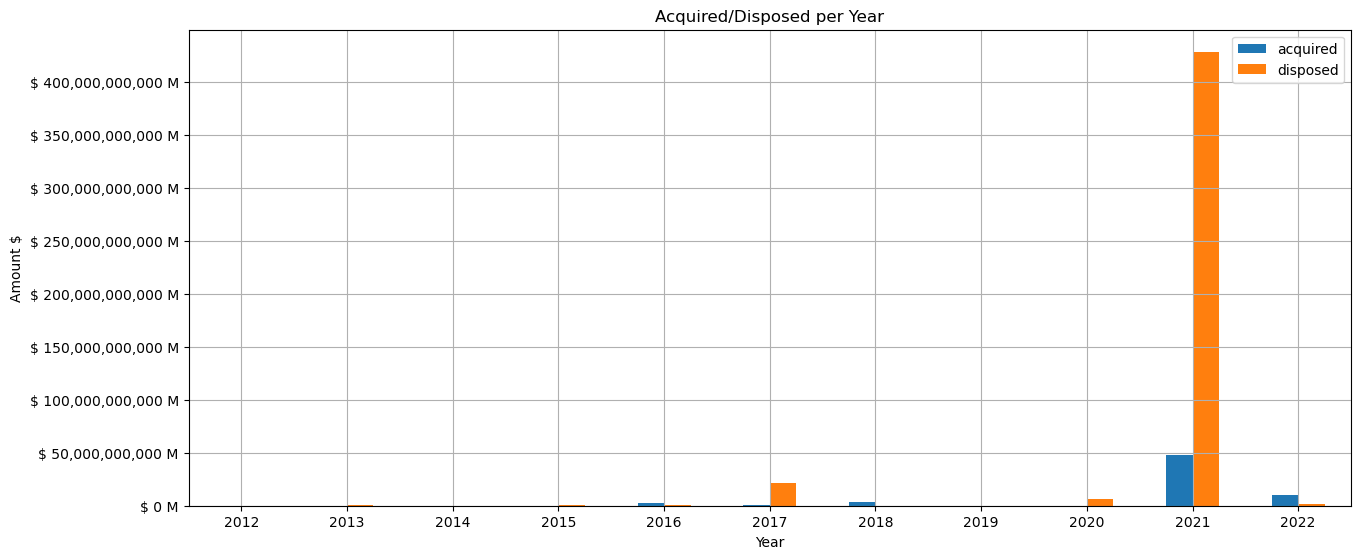

In [17]:
acquired_disposed_trades.index = pd.to_datetime(acquired_disposed_trades.index)
    
acquired_year = acquired_disposed_trades.groupby(pd.Grouper(freq="Y"))["acquired"].sum()
disposed_year = acquired_disposed_trades.groupby(pd.Grouper(freq="Y"))["disposed"].sum()
    
acquired_disposed_year = pd.merge(acquired_year, disposed_year, on="periodOfReport", how="outer")
    
ax = acquired_disposed_year.plot.bar(stacked=False, figsize=(15, 7), color=['#1f77b4', '#ff7f0e'])
    
ax.grid(True)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
ax.set_xticks(range(acquired_disposed_year.index.size))
ax.set_xticklabels([ts.strftime('%Y') for idx, ts in enumerate(acquired_disposed_year.index)])
ax.set_xlabel("Year")
ax.set_ylabel("Amount $")
ax.set_title("Acquired/Disposed per Year")
ax.figure.autofmt_xdate(rotation=0, ha='center')
    
plt.show()

In [18]:
#df_oneDay = df[df["periodOfReport"] == "2022-12-28"]

# Create the new DataFrame with the desired columns
df_priceChange = df[["periodOfReport", "sharePrice0", "sharePriceChange1", "sharePriceChange7", "sharePriceChange30", "sharePriceChange90", "sharePriceChange360"]]

# Display the first lines of the new DataFrame for verification
df_priceChange.head(10)

,periodOfReport,sharePrice0,sharePriceChange1,sharePriceChange7,sharePriceChange30,sharePriceChange90,sharePriceChange360
12,2022-12-28,46.68,0.0,-0.038132,0.075407,0.170737,0.548415
13,2022-12-28,46.68,0.0,-0.038132,0.075407,0.170737,0.548415
14,2022-12-28,46.68,0.0,-0.038132,0.075407,0.170737,0.548415
15,2022-12-28,46.68,0.0,-0.038132,0.075407,0.170737,0.548415
17,2022-12-28,109.12,0.0,0.038123,0.632790,0.732955,1.332845
21,2022-12-28,90.15,0.0,-0.047587,-0.030283,-0.156406,0.325458
22,2022-12-28,90.15,0.0,-0.047587,-0.030283,-0.156406,0.325458
23,2022-12-28,90.15,0.0,-0.047587,-0.030283,-0.156406,0.325458
26,2022-12-28,39.21,0.0,-0.096149,0.060954,-0.098699,0.321347
27,2022-12-28,39.21,0.0,-0.096149,0.060954,-0.098699,0.321347


## 3.2 Distribution of variables
Now we visualize the trading distribution for different roles within the company: isDirector, isOfficer, and isTenPercentOwner. We group the data by transaction type (bought or sold) for each role, aggregate the total amounts, and plot the results. It is important to note that there might be an overlap between positions since individuals can hold multiple roles simultaneously.



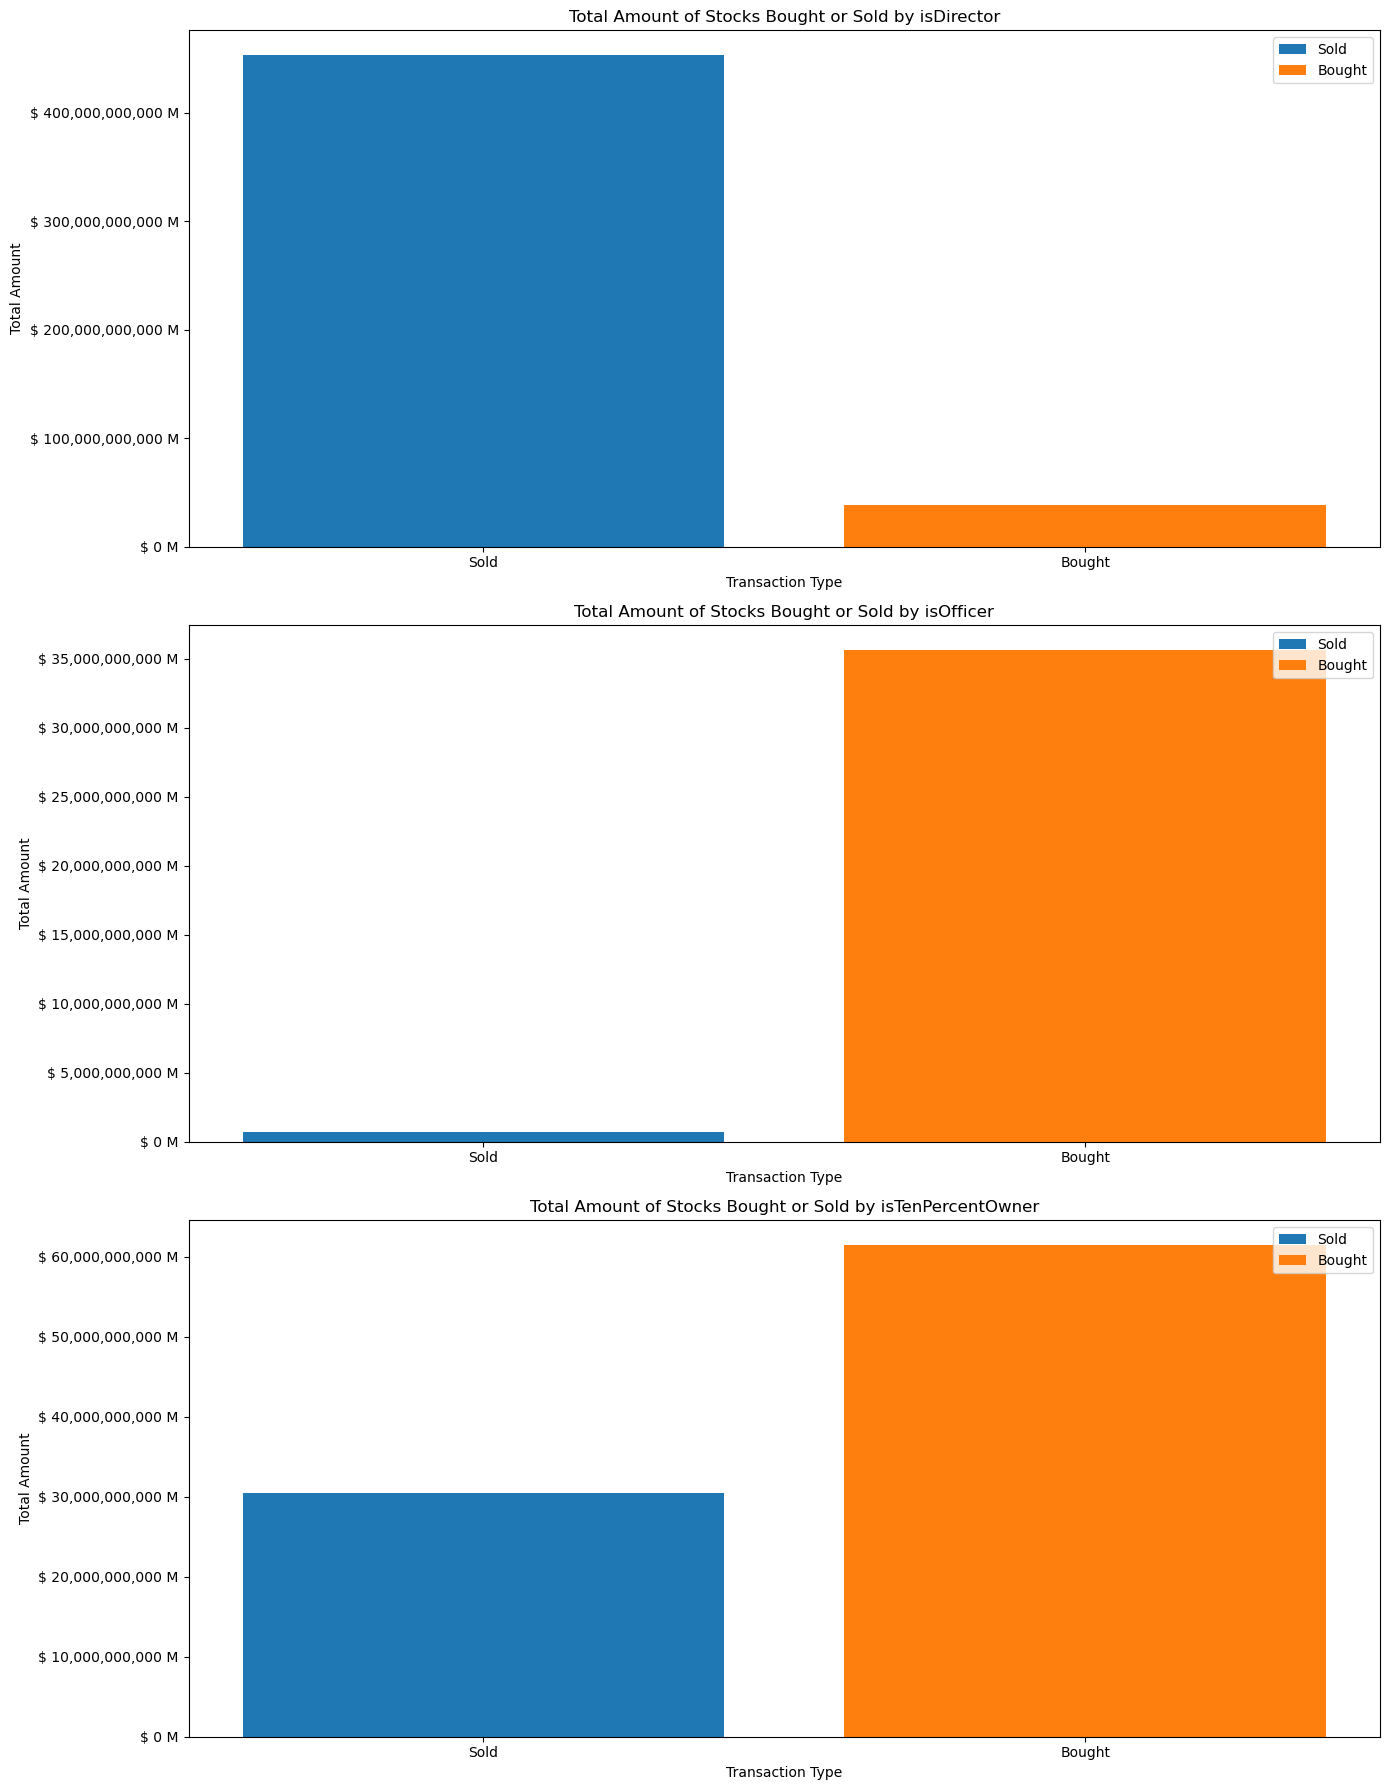

In [19]:
# Define the roles
roles = ['isDirector', 'isOfficer', 'isTenPercentOwner']

# Set up the plotting environment
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 18))

for i, role in enumerate(roles):
    # Group by role and transaction type, and sum the total
    role_totals = df[df[role]].groupby('acquiredDisposed')['total'].sum().fillna(0)
    
    # Plot the data
    bars = axes[i].bar(role_totals.index.map({False: 'Sold', True: 'Bought'}), role_totals.values, color=['#1f77b4', '#ff7f0e'])
    axes[i].set_title(f'Total Amount of Stocks Bought or Sold by {role}')
    axes[i].set_xlabel('Transaction Type')
    axes[i].set_ylabel('Total Amount')
    axes[i].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
    # Set legend
    axes[i].legend(bars, ['Sold', 'Bought'], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

We begin by creating a copy of the original DataFrame to avoid modifying the original data. Next, we replace any infinite values with NaN to handle these as missing values. We then remove all rows containing any NaN values to clean the dataset.

After ensuring that the cleaned DataFrame (df_cleaned) contains data, we calculate the mean returns for each transaction type (bought or sold) by grouping the data based on the acquiredDisposed column. These mean returns are then printed to provide a summary of the data.

To make the results more readable, we map the acquiredDisposed values to descriptive labels: ‘Sold’ for False and ‘Bought’ for True. Finally, we plot these mean returns in a bar chart, displaying the average returns for different holding periods (7 days, 30 days, 90 days, and 360 days) by transaction type. This visualization helps to clearly understand the performance of stocks over various time frames based on whether they were bought or sold.

Data available after cleaning: 1179349 rows
Average Returns by Transaction Type:
                  sharePriceChange7  sharePriceChange30  sharePriceChange90  \
acquiredDisposed                                                              
False                      0.005107            0.007866            0.026030   
True                       0.008427            0.014796            0.033479   

                  sharePriceChange360  
acquiredDisposed                       
False                        0.099600  
True                         0.109076  


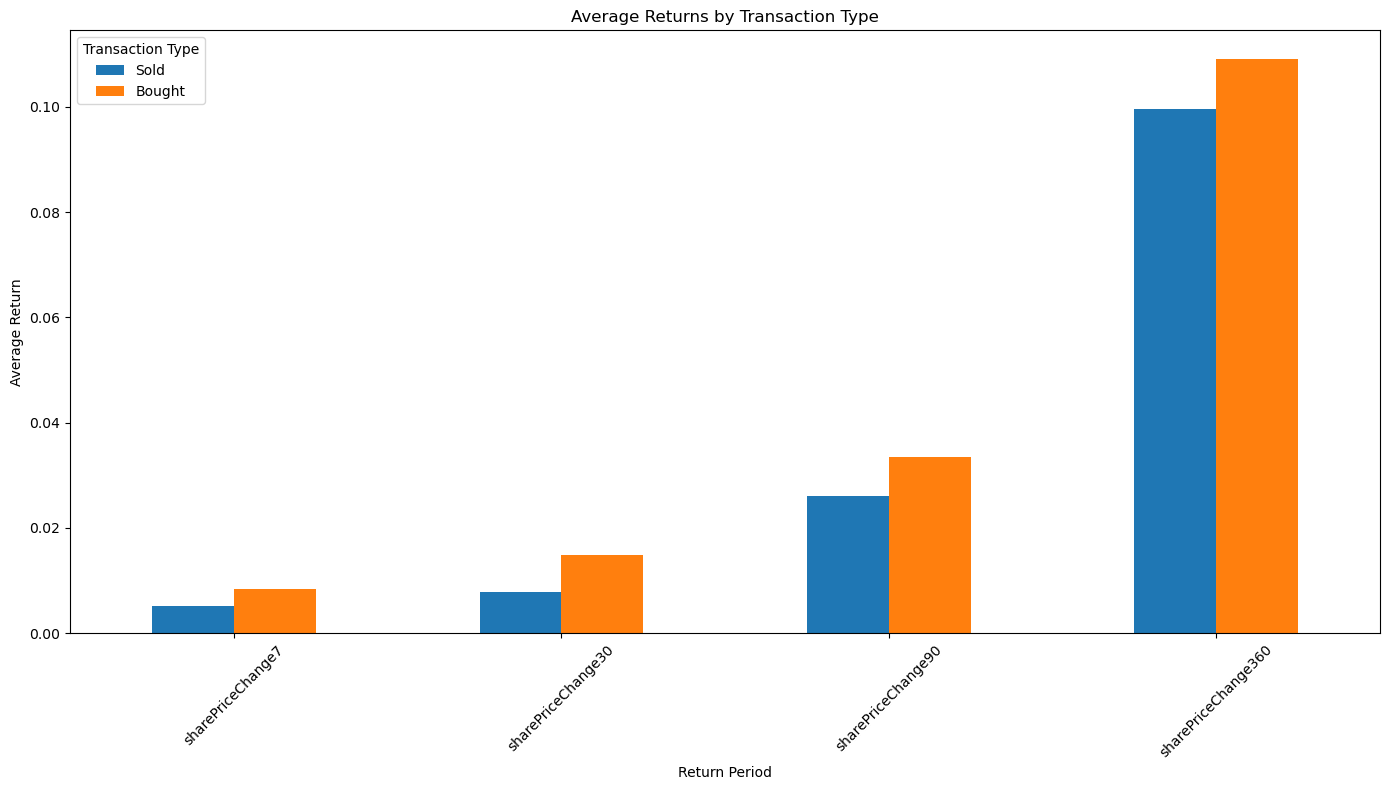

In [20]:
# Create a copy of the original DataFrame to avoid modifying it
df_copy = df.copy()

# Replace Inf values with NaN
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove all rows with any NaN values in the entire DataFrame
df_cleaned = df_copy.dropna()

# Ensure df_cleaned has data
if df_cleaned.empty:
    print("No data available after removing NaN and Inf values")
else:
    print(f"Data available after cleaning: {len(df_cleaned)} rows")

    # Calculate mean returns for each transaction type (acquiredDisposed)
    mean_returns = df_cleaned.groupby('acquiredDisposed')[['sharePriceChange7', 'sharePriceChange30', 'sharePriceChange90', 'sharePriceChange360']].mean()

    # Print the average returns
    print("Average Returns by Transaction Type:")
    print(mean_returns)

    # Map acquiredDisposed values to descriptive labels
    mean_returns.index = mean_returns.index.map({False: 'Sold', True: 'Bought'})

    # Plot the mean returns
    mean_returns.T.plot(kind='bar', figsize=(14, 8))
    plt.title('Average Returns by Transaction Type')
    plt.xlabel('Return Period')
    plt.ylabel('Average Return')
    plt.legend(title='Transaction Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

We observe that the average returns following an insider purchase are higher than those following an insider sale across all holding periods. This suggests that there could be a correlation between insider buying or selling activity and subsequent stock price movements. In the following analysis, we will employ machine learning techniques to further investigate and quantify this potential relationship.

## 3.3 Normal Distribution

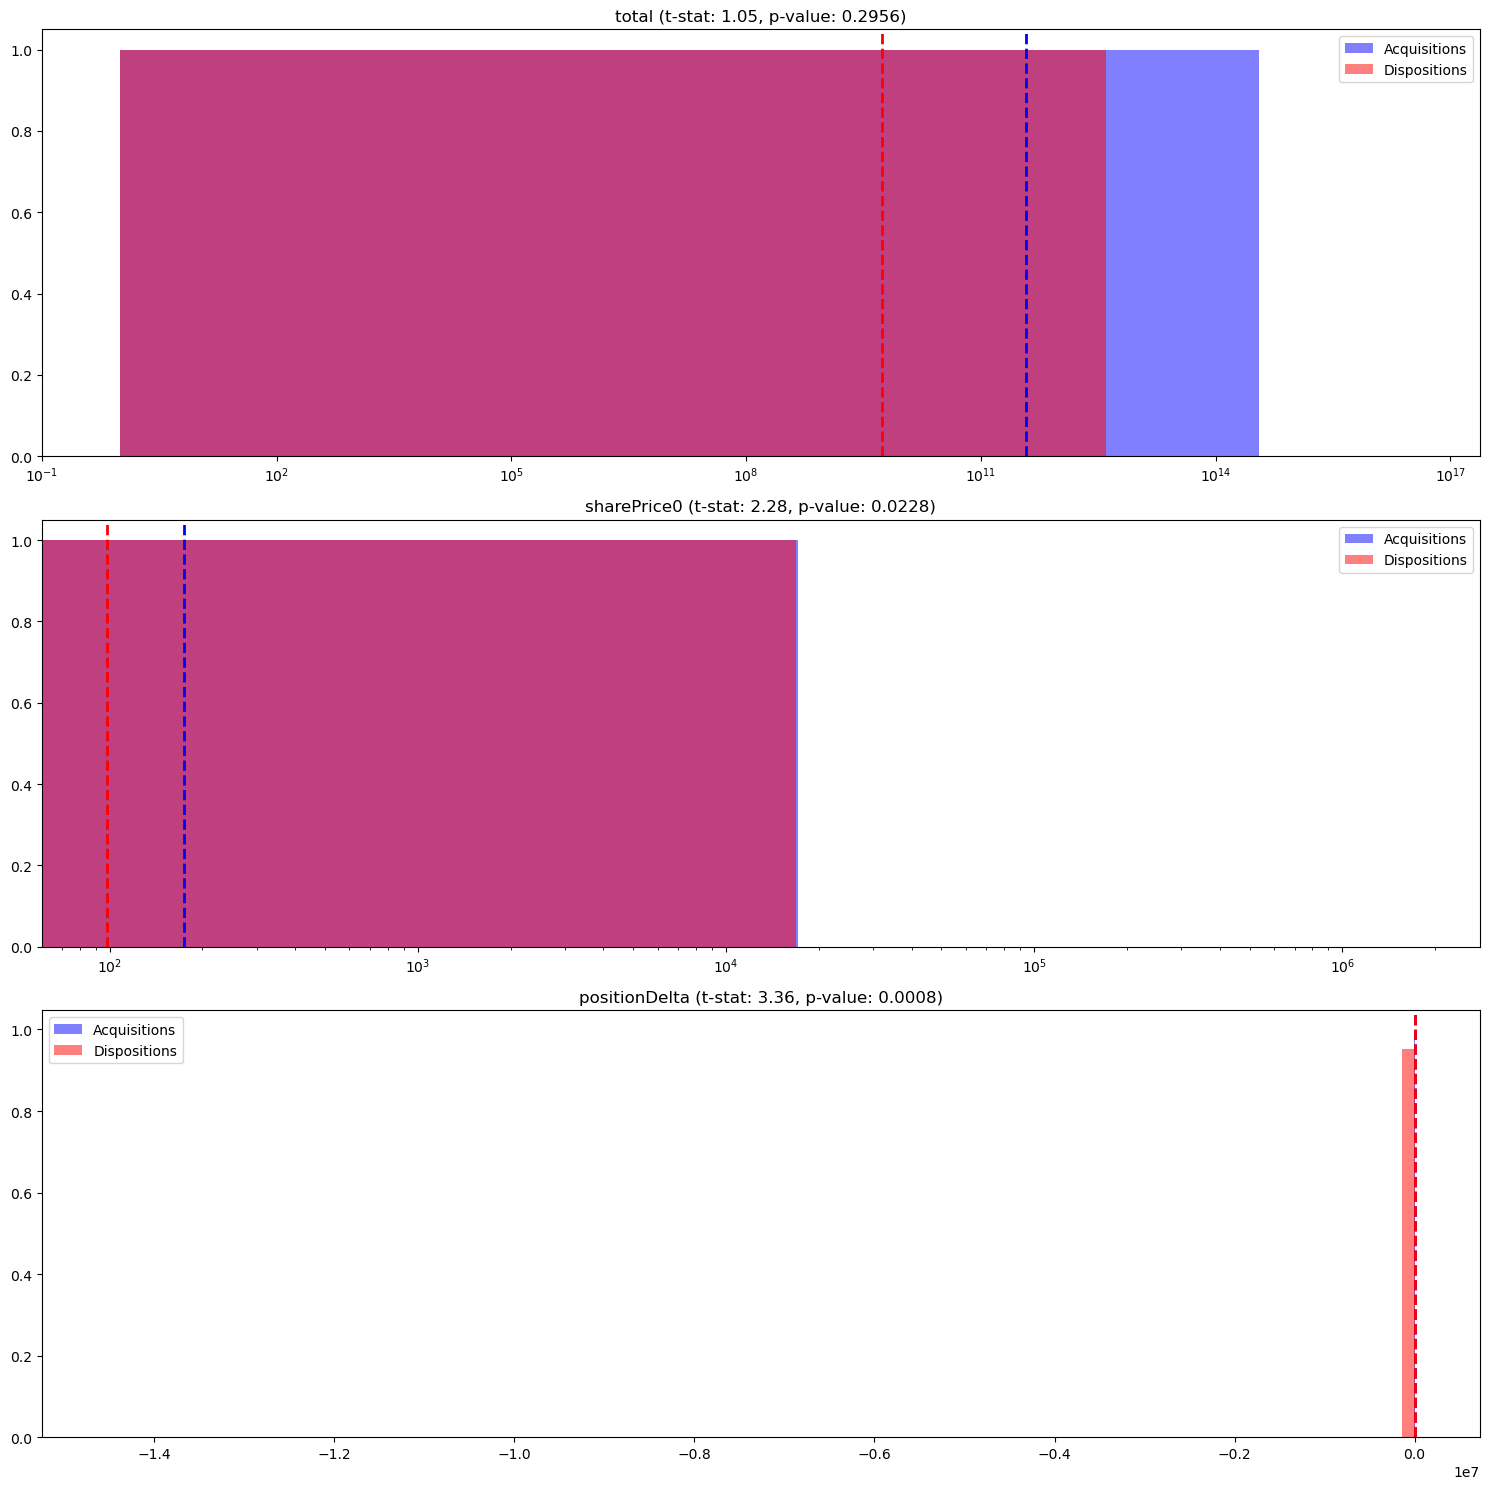

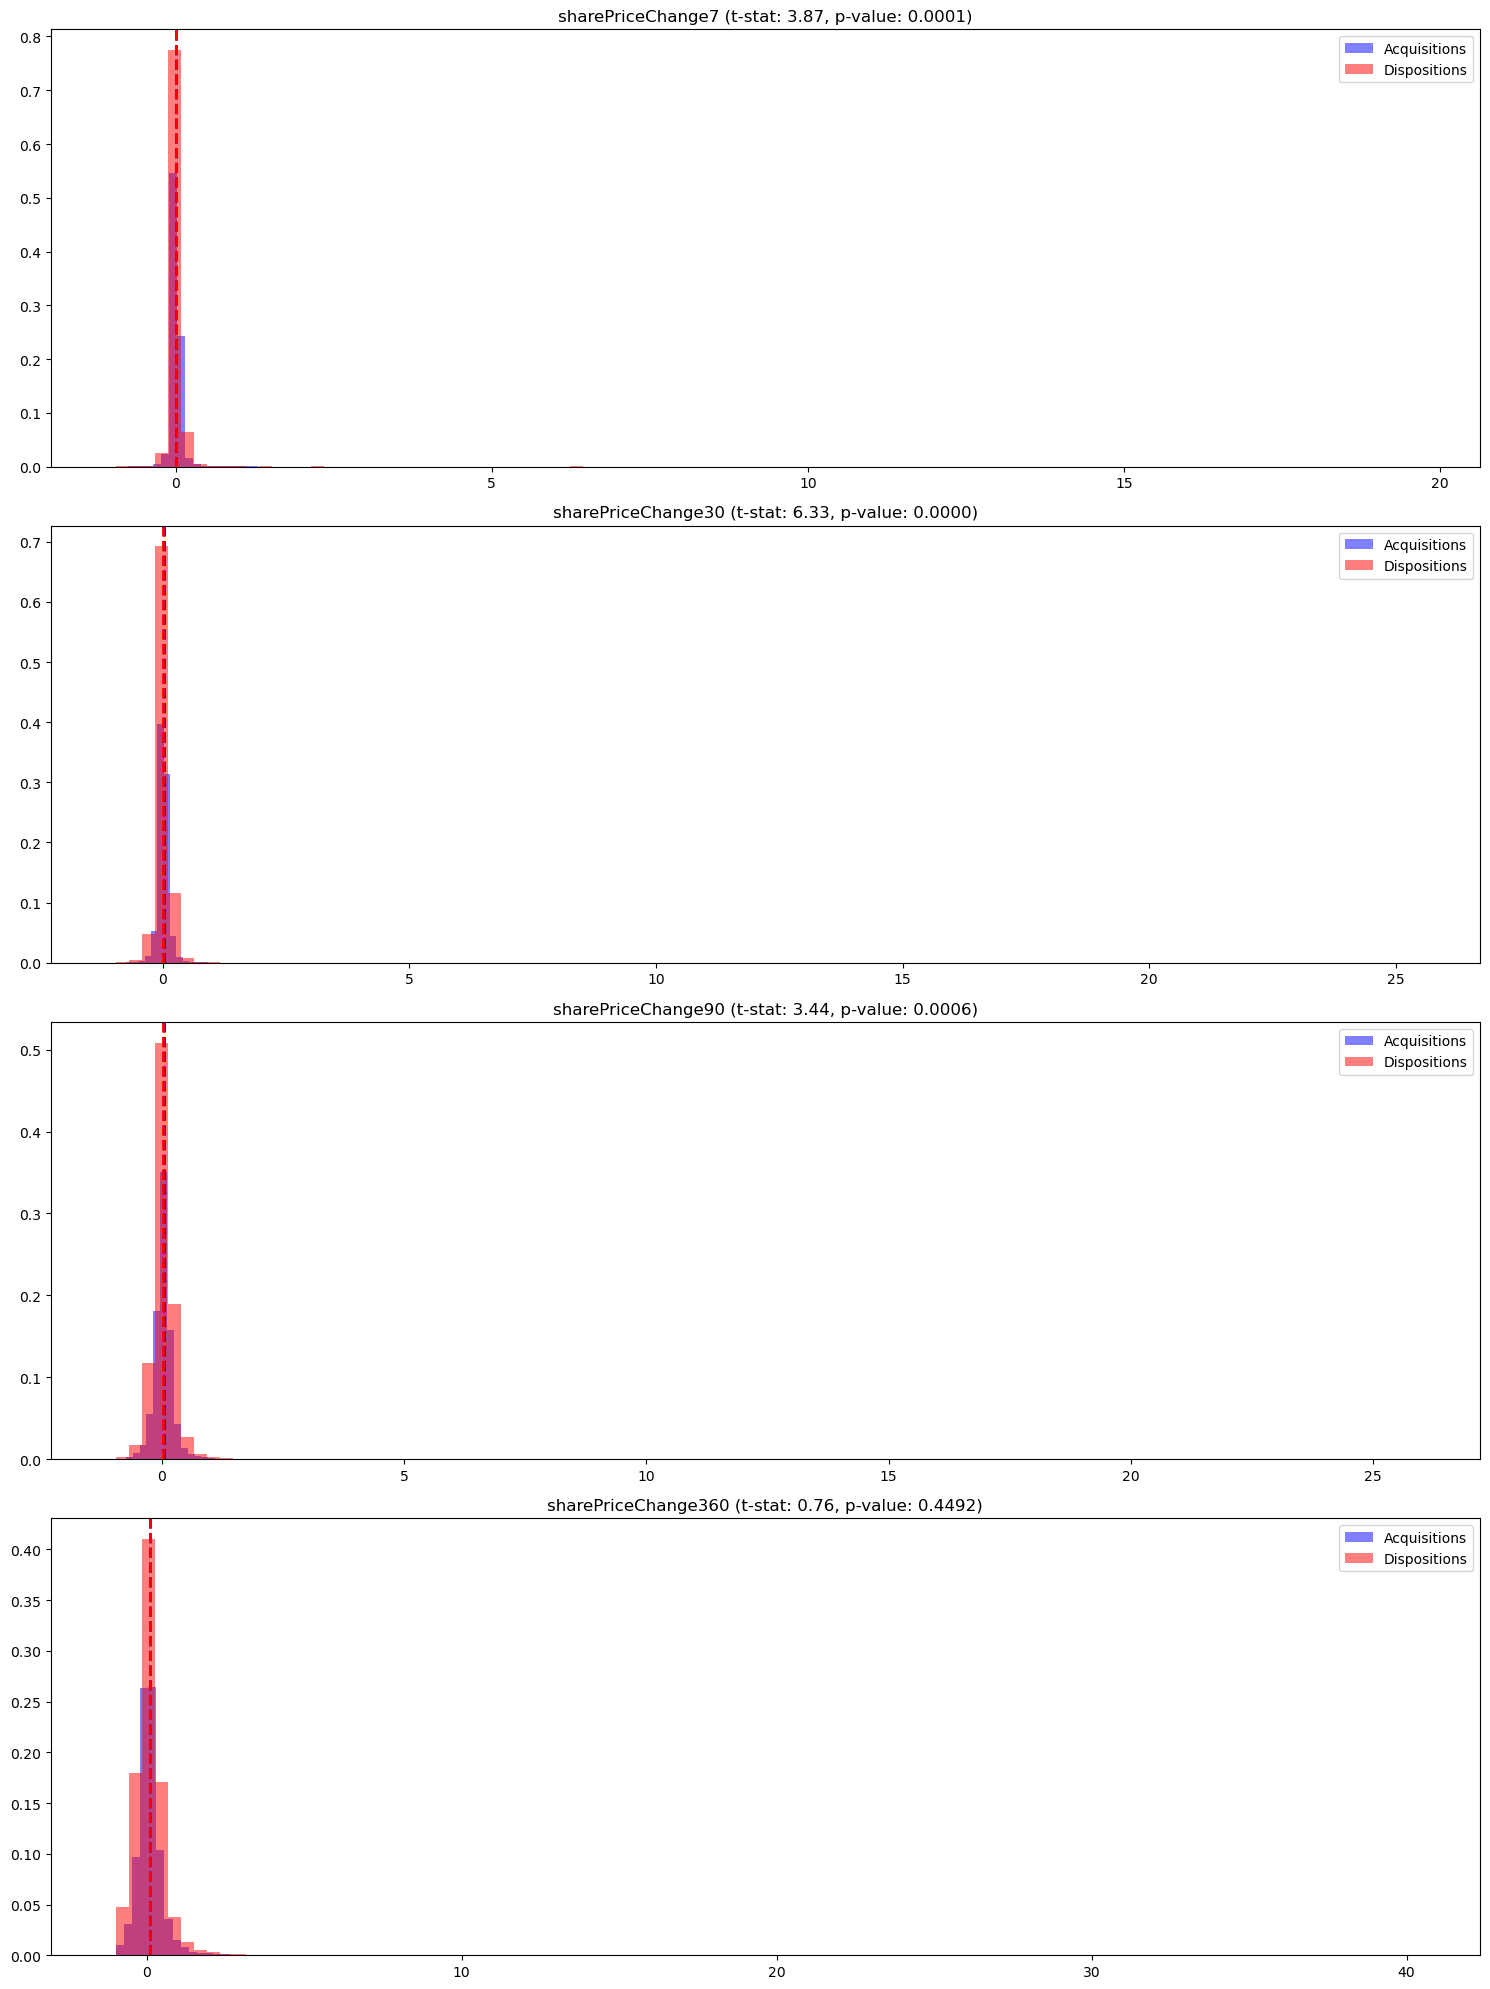

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Separate dataframes based on acquisition type
acquisitions_df = df[df['acquiredDisposed'] == True]
dispositions_df = df[df['acquiredDisposed'] == False]

# Select features for analysis (excluding target variables and binary flags)
features = ['total', 'sharePrice0', 'positionDelta']
target_vars = ['sharePriceChange7', 'sharePriceChange30', 'sharePriceChange90', 'sharePriceChange360']

# Function to create histogram data
def get_hist_data(data, bins=100):
    # Remove infinite values and convert to float64
    data_clean = data[np.isfinite(data)].astype(np.float64)
    if len(data_clean) == 0:
        return None, None  # Return None if all data is invalid
    hist, bin_edges = np.histogram(data_clean, bins=bins)
    return bin_edges, hist

# Function to safely compute mean
def safe_mean(data):
    return np.mean(data[np.isfinite(data)])

# Function to safely check if we should use log scale
def should_use_log_scale(data):
    non_zero = data[(data != 0) & np.isfinite(data)]
    if len(non_zero) == 0:
        return False
    return non_zero.max() / non_zero.min() > 100

def plot_distributions(features, df_a, df_b, name_a, name_b, max_samples):
    fig, axs = plt.subplots(len(features), 1, figsize=(15, 5 * len(features)))
    axs = axs.ravel()

    for i, feature in enumerate(features):
        a = df_a[feature]
        b = df_b[feature]
        
        # Reduce sample size if necessary
        if len(a) > max_samples:
            a = a.sample(n=max_samples, random_state=42)
        if len(b) > max_samples:
            b = b.sample(n=max_samples, random_state=42)
        
        # Ensure equal sample sizes for t-test
        min_samples = min(len(a), len(b))
        a = a.sample(n=min_samples, random_state=42)
        b = b.sample(n=min_samples, random_state=42)
        
        # Remove non-finite values for t-test
        a_clean = a[np.isfinite(a)]
        b_clean = b[np.isfinite(b)]
        
        # Running t-tests only if we have valid data
        if len(a_clean) > 0 and len(b_clean) > 0:
            t_stat, p_value = stats.ttest_ind(a_clean, b_clean)
        else:
            t_stat, p_value = np.nan, np.nan
        
        # Create distribution plots using matplotlib's hist
        a_bins, a_hist = get_hist_data(a)
        b_bins, b_hist = get_hist_data(b)
        
        if a_bins is not None and b_bins is not None:
            axs[i].hist(a, bins=a_bins, weights=np.ones_like(a)/len(a), alpha=0.5, label=name_a, color='blue')
            axs[i].hist(b, bins=b_bins, weights=np.ones_like(b)/len(b), alpha=0.5, label=name_b, color='red')
            
            axs[i].set_title(f"{feature} (t-stat: {t_stat:.2f}, p-value: {p_value:.4f})")
            axs[i].legend()
            
            # Add vertical lines for means
            a_mean = safe_mean(a)
            b_mean = safe_mean(b)
            axs[i].axvline(a_mean, color='blue', linestyle='dashed', linewidth=2)
            axs[i].axvline(b_mean, color='red', linestyle='dashed', linewidth=2)
            
            # Set x-axis to log scale if the feature has a wide range
            if should_use_log_scale(a) or should_use_log_scale(b):
                axs[i].set_xscale('log')
                axs[i].set_xlim(left=max(a.min(), b.min()) / 10)  # Set a non-zero lower limit
        else:
            axs[i].text(0.5, 0.5, "Insufficient valid data for plotting", 
                        ha='center', va='center', transform=axs[i].transAxes)

    plt.tight_layout()
    plt.show()

# Set maximum number of samples to use (adjust based on your memory constraints)
max_samples = 100000

# Plot distributions for features
plot_distributions(features, acquisitions_df, dispositions_df, "Acquisitions", "Dispositions", max_samples)

# Plot distributions for target variables
plot_distributions(target_vars, acquisitions_df, dispositions_df, "Acquisitions", "Dispositions", max_samples)

In [22]:
## 3.4 Correlation

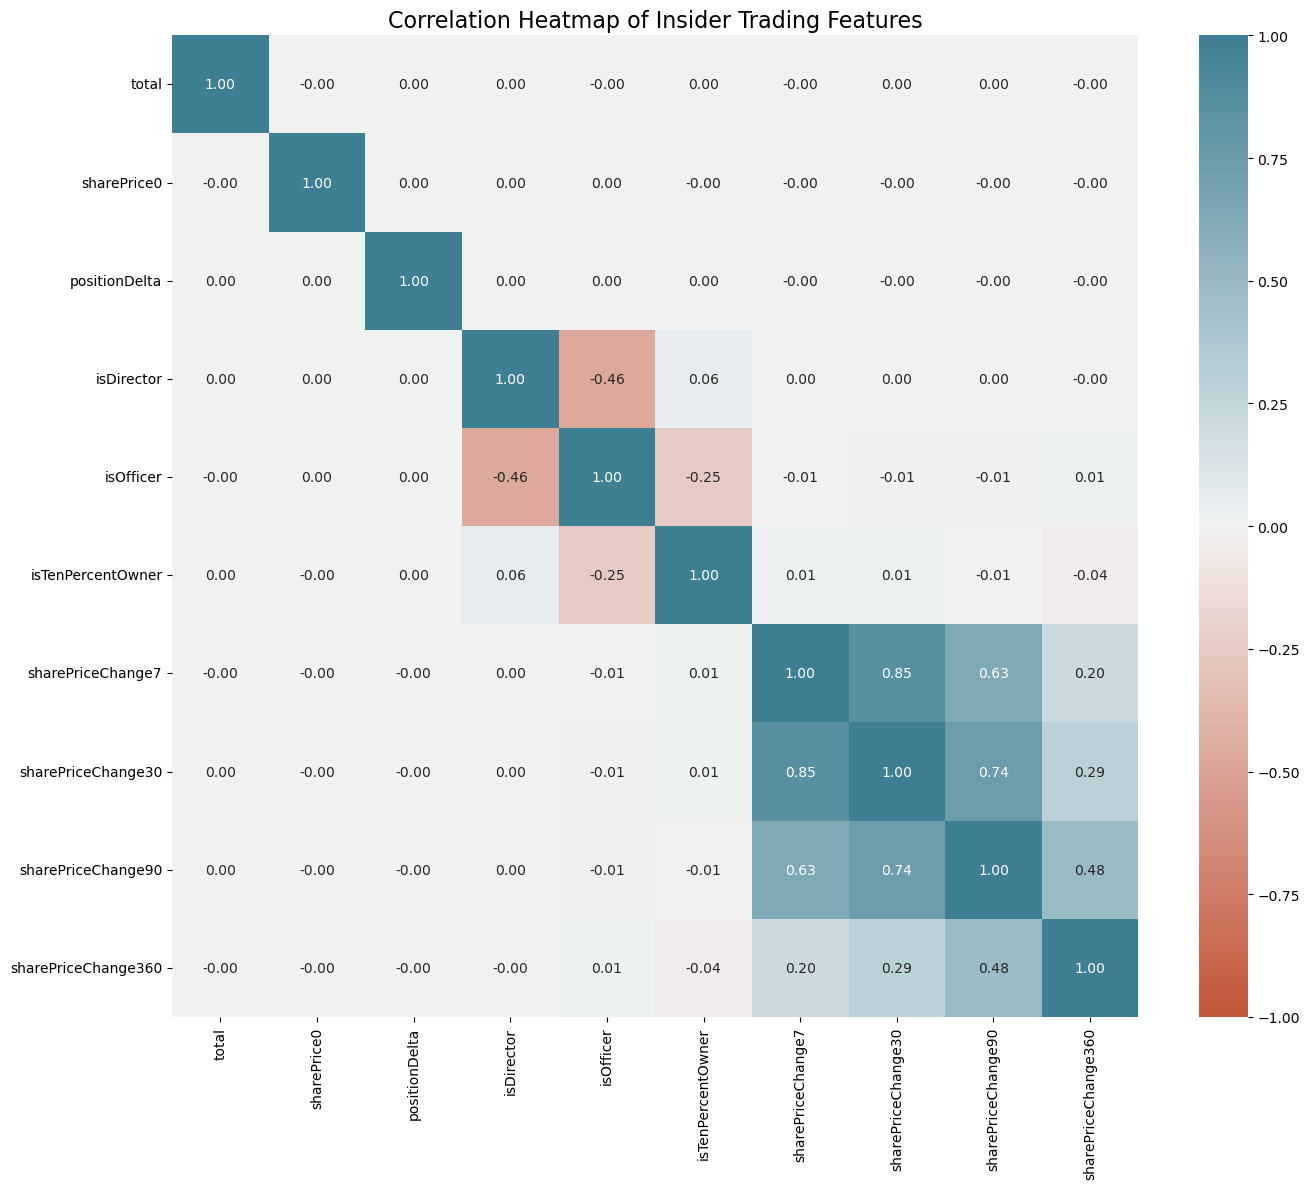

In [23]:
# Select relevant features for correlation analysis
features = ['total', 'sharePrice0', 'positionDelta', 'isDirector', 'isOfficer', 'isTenPercentOwner',
            'sharePriceChange7', 'sharePriceChange30', 'sharePriceChange90', 'sharePriceChange360']

# Create correlation matrix
corr_matrix = df[features].corr()

# Create the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, 
            vmin=-1, 
            vmax=1, 
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            annot=True,
            fmt='.2f',
            center=0)

plt.title('Correlation Heatmap of Insider Trading Features', fontsize=16)
plt.tight_layout()
plt.show()

In [24]:
## 3.5 Boxplots

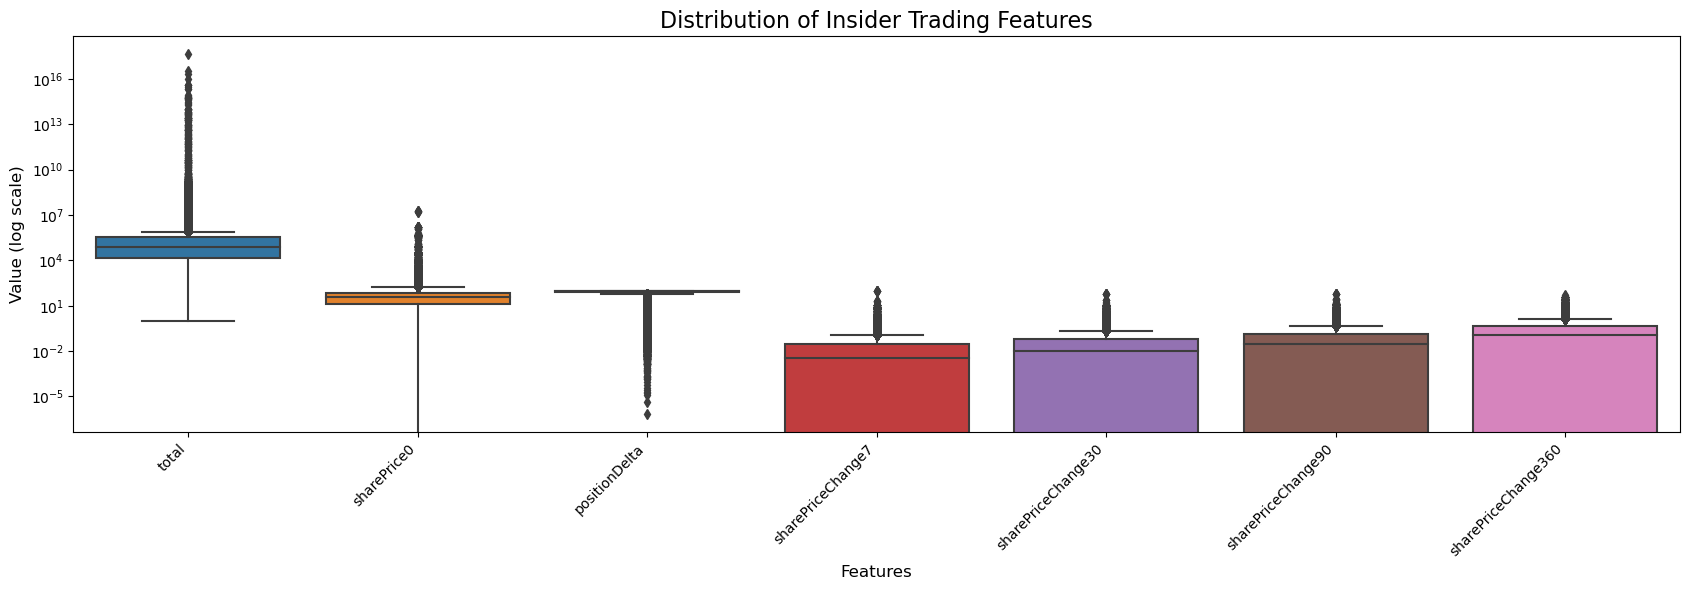

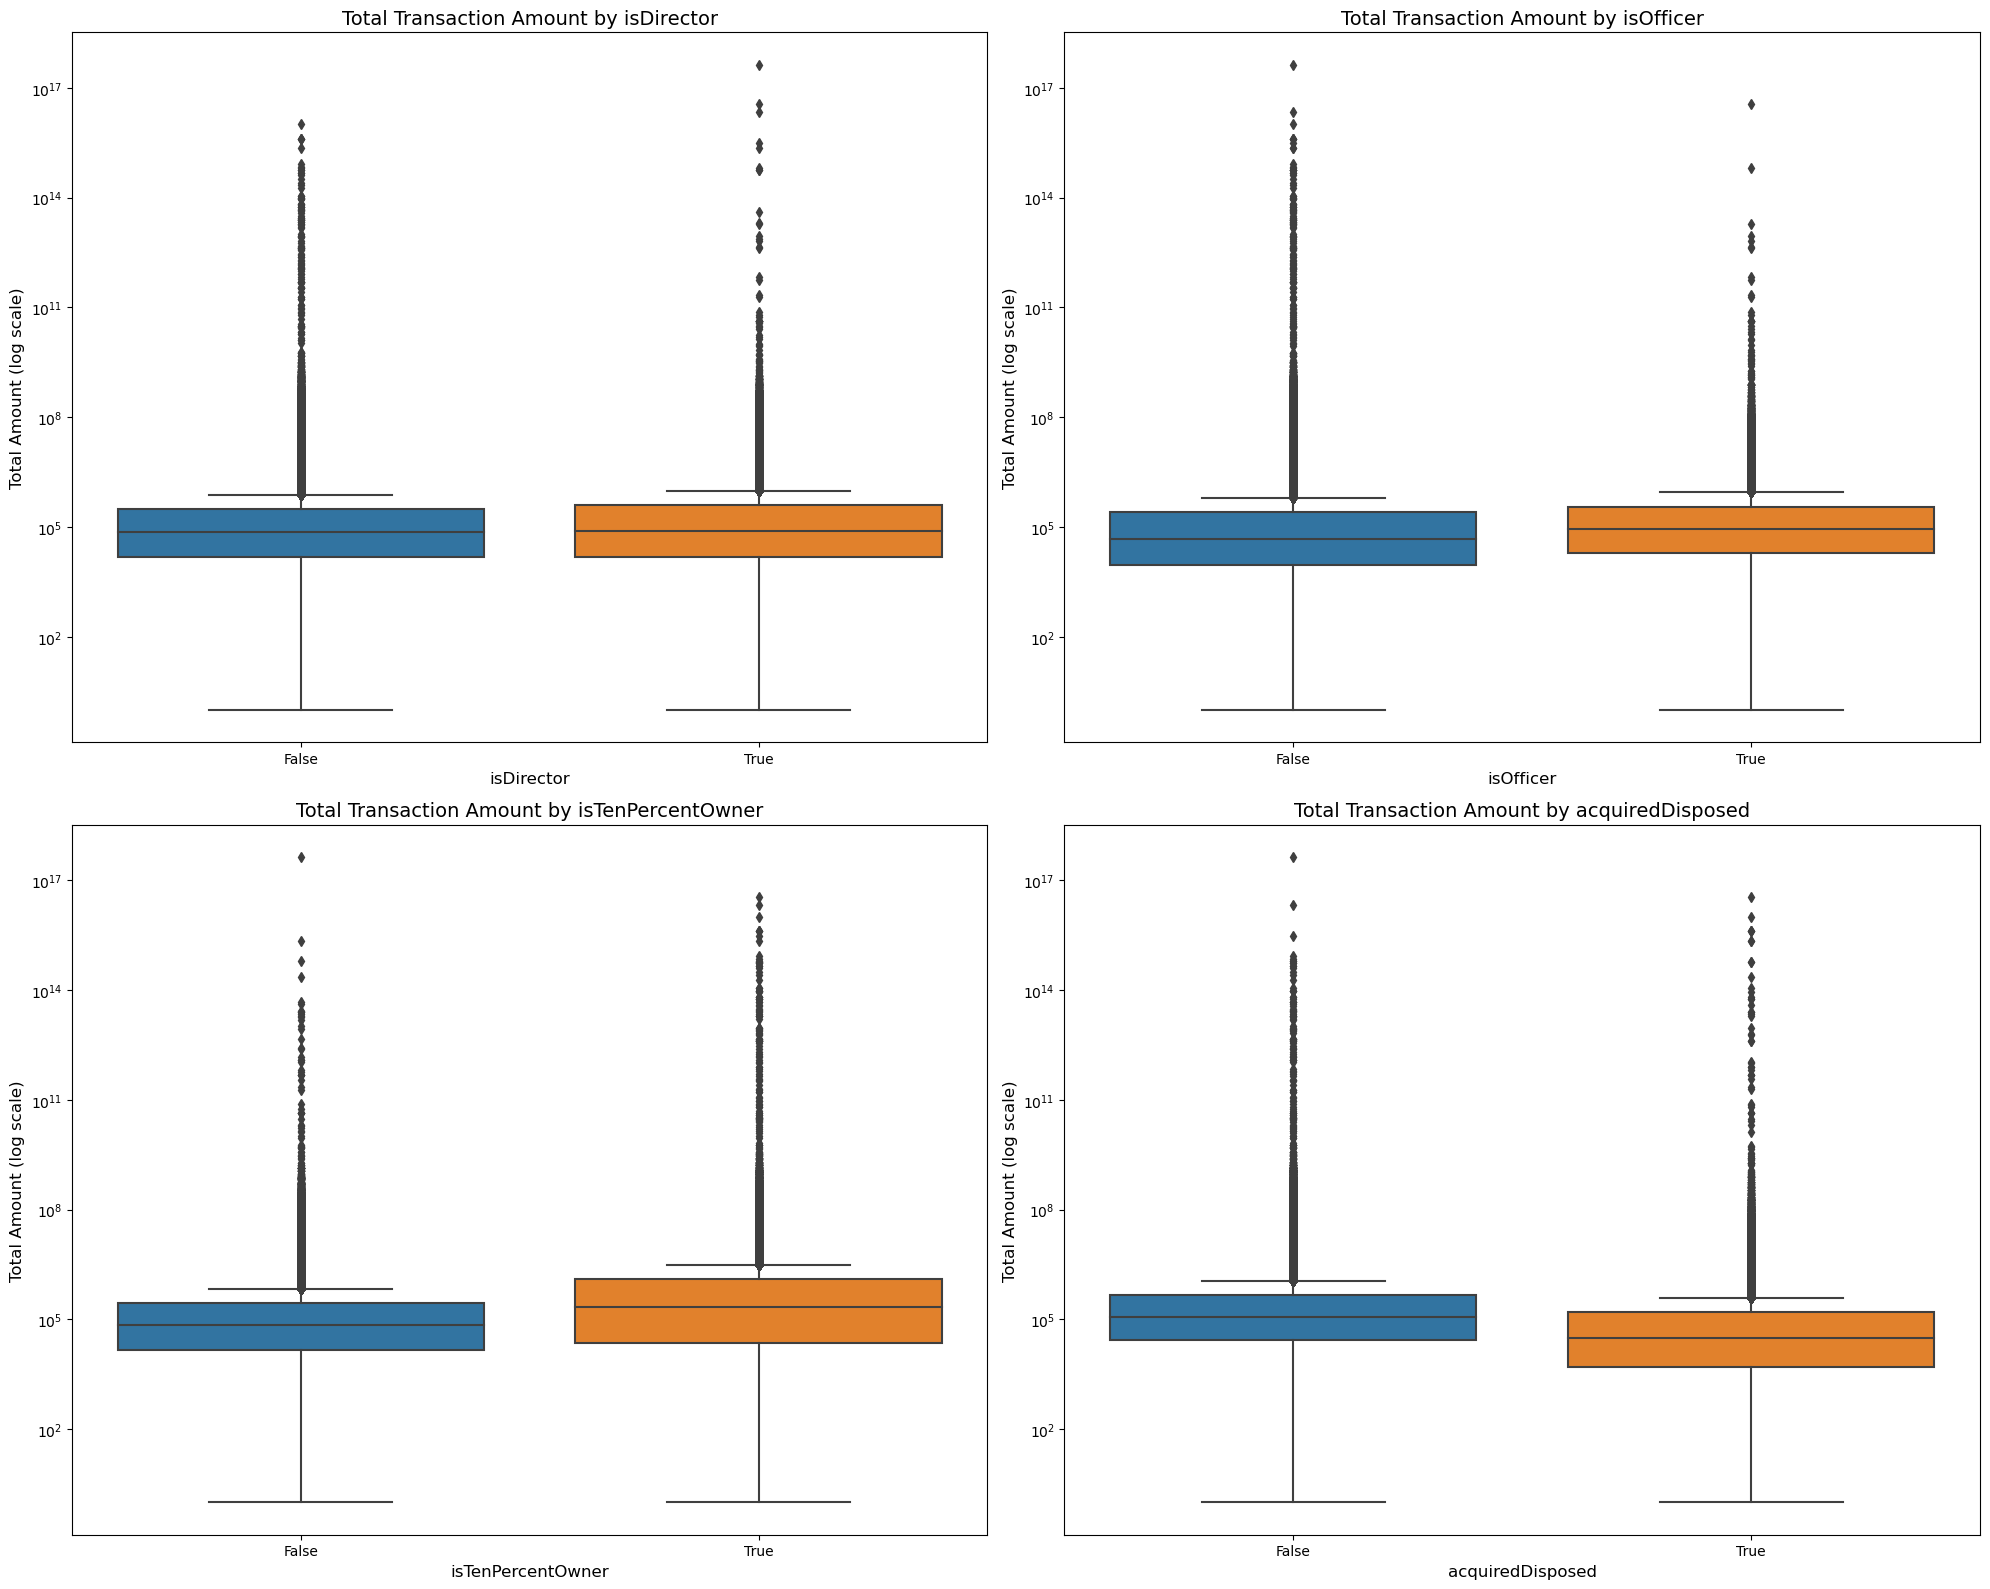

In [25]:
# Select relevant numerical features for boxplots
features = ['total', 'sharePrice0', 'positionDelta', 
            'sharePriceChange7', 'sharePriceChange30', 'sharePriceChange90', 'sharePriceChange360']

# Melt the dataframe to long format for easier plotting
df_melt = pd.melt(df[features], var_name='Feature', value_name='Value')

# Create the boxplots
fig, ax = plt.subplots(1, figsize=(17, 6))
sns.boxplot(data=df_melt, x='Feature', y='Value', ax=ax)

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Set y-axis to log scale
ax.set_yscale("log")

# Add title and labels
plt.title('Distribution of Insider Trading Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Value (log scale)', fontsize=12)

# Adjust layout
plt.tight_layout()

plt.show()

# Additional boxplots for binary features
binary_features = ['isDirector', 'isOfficer', 'isTenPercentOwner', 'acquiredDisposed']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, feature in enumerate(binary_features):
    sns.boxplot(data=df, x=feature, y='total', ax=axes[i])
    axes[i].set_yscale("log")
    axes[i].set_title(f'Total Transaction Amount by {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Total Amount (log scale)', fontsize=12)

plt.tight_layout()
plt.show()

# 4. Machine Learning

## 4.1 Data Splitting
We define a function clean_data to clean and preprocess the data. In this function, we replace infinity values with NaN, remove rows with NaN values, and cap extreme values at the 1st and 99th percentiles. Finally, we clean the data by applying the clean_data function to the DataFrame.

In [26]:
import numpy as np

# Function to clean and preprocess data
def clean_data(df):
    # Replace infinity with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Remove rows with NaN values
    df = df.dropna()
    
    # Cap extreme values (e.g., 99th percentile)
    for col in df.select_dtypes(include=[np.number]).columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    
    return df

# Clean the data
df = clean_data(df)

We select specific columns from the DataFrame df for our feature matrix X and target matrix y. The selected features for X include ‘total’, ‘sharePrice0’, ‘positionDelta’, ‘isDirector’, ‘isOfficer’, ‘isTenPercentOwner’, and ‘type’. The target variables y include ‘sharePriceChange7’, ‘sharePriceChange30’, ‘sharePriceChange90’, and ‘sharePriceChange360’. Additionally, we create a new feature isAcquisition in X to indicate whether the transaction was an acquisition. Finally, we split the data into training and testing sets using an 80-20 split, with a random seed of 42 for reproducibility.

In [27]:
X = df[[ 'total', 'sharePrice0', 'positionDelta', 'isDirector', 'isOfficer', 'isTenPercentOwner', "type"]]
y = df[['sharePriceChange7', 'sharePriceChange30', 'sharePriceChange90', 'sharePriceChange360']]

X['isAcquisition'] = (df['acquiredDisposed'] == True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X.head(10)

,total,sharePrice0,positionDelta,isDirector,isOfficer,isTenPercentOwner,type,isAcquisition
12,15115.0,46.68,99.714397,True,True,False,True,True
13,35312.0,46.68,99.713579,True,True,False,True,False
14,647786.0,46.68,89.066311,True,True,False,True,True
15,1514475.0,46.68,87.724103,True,True,False,True,False
17,248941.0,109.12,93.392507,False,True,False,True,True
21,25044.0,90.15,91.428571,True,True,False,True,True
22,25024.0,90.15,92.153765,True,True,False,True,True
23,25063.0,90.15,92.769907,True,True,False,True,True
26,131204.0,39.21,97.467101,False,False,False,True,True
27,253687.0,39.21,95.336811,False,False,False,True,True


In [29]:
y.head(10)

,sharePriceChange7,sharePriceChange30,sharePriceChange90,sharePriceChange360
12,-0.038132,0.075407,0.170737,0.548415
13,-0.038132,0.075407,0.170737,0.548415
14,-0.038132,0.075407,0.170737,0.548415
15,-0.038132,0.075407,0.170737,0.548415
17,0.038123,0.371404,0.706904,1.332845
21,-0.047587,-0.030283,-0.156406,0.325458
22,-0.047587,-0.030283,-0.156406,0.325458
23,-0.047587,-0.030283,-0.156406,0.325458
26,-0.096149,0.060954,-0.098699,0.321347
27,-0.096149,0.060954,-0.098699,0.321347


## 4.2 Regression
We define a set of models along with their hyperparameter grids for training. These models include Linear Regression, Ridge Regression, Lasso Regression, Random Forest Regressor, XGBoost Regressor, LightGBM Regressor, and CatBoost Regressor. Each model is accompanied by a specific set of hyperparameters to be tuned using grid search.

Next, we create a function train_and_evaluate to handle the training and evaluation of these models. This function performs grid search with cross-validation to identify the optimal hyperparameters, fits the model on the training data, and evaluates it on the test data using metrics like mean squared error (MSE) and R-squared (R2). The function returns both the results and the best-fitted models.

To display the results and feature importances, we define another function print_results_and_importances. This function prints out the best parameters, cross-validated R2 score, test MSE, and test R2 for each model. For tree-based models, it also shows the feature importances.

We then proceed to train and evaluate the models for each target variable (sharePriceChange7, sharePriceChange30, sharePriceChange90, sharePriceChange360) separately for acquisition and disposition transactions. The data is split into acquisition and disposition subsets, and models are trained on these subsets. The results and feature importances are then printed.

Finally, predictions are made using the best models for each target variable and acquisition type. We print a sample of these predictions to illustrate how well the models perform.

In [30]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [31]:
# Define models with hyperparameter grids
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'alpha': np.logspace(-3, 3, 5)}),
    'Lasso Regression': (Lasso(), {'alpha': np.logspace(-3, 3, 5)}),
    'Random Forest Regressor': (RandomForestRegressor(), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }),
    'XGBoost Regressor': (xgb.XGBRegressor(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }),
    'LightGBM Regressor': (lgb.LGBMRegressor(verbose=-1), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 62]
    }),
    'CatBoost Regressor': (cb.CatBoostRegressor(verbose=0), {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 6]
    })
}

def train_with_timeout(model, X_train, y_train, timeout=300):
    with ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(model.fit, X_train, y_train)
        try:
            return future.result(timeout=timeout)
        except TimeoutError:
            print(f"Training timed out after {timeout} seconds")
            return None

def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = {}
    fitted_models = {}
    for name, (model, param_grid) in models.items():
        print(f"Training {name}")
        try:
            random_search = RandomizedSearchCV(model, param_grid, n_iter=3, cv=3, scoring='r2', n_jobs=-1, random_state=42)
            best_model = train_with_timeout(random_search, X_train, y_train)
            
            if best_model is None:
                raise Exception("Model training timed out")
            
            y_pred = best_model.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            results[name] = {
                'Best Parameters': random_search.best_params_,
                'CV R2': random_search.best_score_,
                'Test MSE': mse,
                'Test MAE': mae,
                'Test R2': r2,
                'Predictions': y_pred
            }
            fitted_models[name] = best_model
        except Exception as e:
            print(f"Error in {name}: {str(e)}")
            results[name] = {
                'Best Parameters': None,
                'CV R2': np.nan,
                'Test MSE': np.nan,
                'Test MAE': np.nan,
                'Test R2': -np.inf,
                'Predictions': None
            }
    return results, fitted_models

def plot_feature_importances(best_model, X, target):
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        feature_names = X.columns
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
        importance_df = importance_df.sort_values('importance', ascending=True)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['feature'], importance_df['importance'])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Feature Importances for {target}')
        plt.tight_layout()
        plt.show()

def plot_model_performance(y_test, predictions, model_name, target):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - {target}')
    plt.tight_layout()
    plt.show()

def plot_residuals(y_test, predictions, model_name, target):
    residuals = y_test - predictions
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predictions, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for {model_name} - {target}')
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results, target):
    model_names = list(results.keys())
    r2_scores = [results[model]['Test R2'] for model in model_names]
    mse_scores = [results[model]['Test MSE'] for model in model_names]
    mae_scores = [results[model]['Test MAE'] for model in model_names]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    ax1.bar(model_names, r2_scores)
    ax1.set_ylabel('R2 Score')
    ax1.set_title(f'Model Comparison - R2 Score for {target}')
    ax1.tick_params(axis='x', rotation=45)

    ax2.bar(model_names, mse_scores)
    ax2.set_ylabel('Mean Squared Error')
    ax2.set_title(f'Model Comparison - MSE for {target}')
    ax2.tick_params(axis='x', rotation=45)

    ax3.bar(model_names, mae_scores)
    ax3.set_ylabel('Mean Absolute Error')
    ax3.set_title(f'Model Comparison - MAE for {target}')
    ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def main(df):
    X = df[['total', 'sharePrice0', 'positionDelta', 'isDirector', 'isOfficer', 'isTenPercentOwner', 'type']]
    y = df[['sharePriceChange7', 'sharePriceChange30', 'sharePriceChange90', 'sharePriceChange360']]
    X['isAcquisition'] = (df['acquiredDisposed'] == True)

    # Reduce dataset size for testing
    X = X.sample(n=1000, random_state=42)
    y = y.loc[X.index]

    all_results = {}
    best_models = {}

    for acquisition_type in ['Acquisitions', 'Dispositions']:
        print(f"\nTraining models for {acquisition_type}:")
        
        mask = X['isAcquisition'] if acquisition_type == 'Acquisitions' else ~X['isAcquisition']
        X_filtered = X[mask].drop('isAcquisition', axis=1)
        y_filtered = y[mask]
        
        for target in y.columns:
            print(f"\nTarget: {target}")
            
            X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered[target], test_size=0.2, random_state=42)
            results, fitted_models = train_and_evaluate(X_train, X_test, y_train, y_test)
            
            # Find the best model that actually fitted
            best_model_name = max((name for name in results if results[name]['Test R2'] != -np.inf), 
                                  key=lambda x: results[x]['Test R2'],
                                  default=None)
            
            if best_model_name is not None and best_model_name in fitted_models:
                best_model = fitted_models[best_model_name]
                print(f"Best model: {best_model_name}")
                
                plot_feature_importances(best_model, X_filtered, target)
                plot_model_performance(y_test, results[best_model_name]['Predictions'], best_model_name, target)
                plot_residuals(y_test, results[best_model_name]['Predictions'], best_model_name, target)
            else:
                print("No models were successfully fitted.")
            
            plot_model_comparison(results, target)
            
            if target not in all_results:
                all_results[target] = {}
            all_results[target][acquisition_type] = results
            
            if target not in best_models:
                best_models[target] = {}
            best_models[target][acquisition_type] = best_model if best_model_name is not None else None

    return all_results, best_models

if __name__ == "__main__":
    all_results, best_models = main(df)
    print("Analysis completed.")

## 4.3 Classification Models

Now we set up a process for training and evaluating classification models to predict share price changes based on various features. Initially, it configures logging to track the entire process.

The first step involves data preparation, where feature columns (X) and target columns (y) are extracted from a DataFrame (df). The target columns, which represent share price changes over different periods, are converted to binary classes, indicating whether the share price change is positive or not. Additionally, an extra feature is added to X to indicate whether a transaction is an acquisition.

Next we define three classification models (Random Forest, XGBoost, and LightGBM) along with a reduced set of hyperparameters for each. These models will be evaluated to determine the best one for predicting share price changes.

Then we define a function to handle the training and evaluation of these models. This function uses RandomizedSearchCV for hyperparameter tuning and evaluates the models based on metrics such as accuracy, precision, recall, F1 score, ROC AUC, and the confusion matrix. The results and feature importances are logged for further analysis.

Additionally, we create a function to plot the ROC curve for the models, providing a visual representation of their performance.

Then we split the data into acquisitions and dispositions and trains and evaluates the models separately for each category and each target variable (representing different periods of share price change). The results are logged and plotted, offering a comprehensive overview of the models' performance.

Finally, the best models are used to make predictions on the test data. A sample of these predictions is logged, showcasing the models' ability to predict share price changes. The process concludes with the logging of final predictions, ensuring a thorough evaluation and understanding of the models' performance throughout the entire pipeline.


In [32]:
#Prepare data
X = df[['total', 'sharePrice0', 'positionDelta', 'isDirector', 'isOfficer', 'isTenPercentOwner', "type"]]
y = df['sharePriceChange360'] > 0  # Convert to binary outcome

# Filter for acquisitions only
acquisitions_mask = df['acquiredDisposed'] == True
X = X[acquisitions_mask]
y = y[acquisitions_mask]

# Define models with reduced hyperparameter grids
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }),
    'XGBoost': (xgb.XGBClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }),
    'LightGBM': (lgb.LGBMClassifier(random_state=42, verbose=-1), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 63]
    })
}

def train_and_evaluate(model, param_grid, X_train, X_test, y_train, y_test):
    random_search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    return {
        'Best Parameters': random_search.best_params_,
        'CV Accuracy': random_search.best_score_,
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred, average='weighted'),
        'Test Recall': recall_score(y_test, y_pred, average='weighted'),
        'Test F1': f1_score(y_test, y_pred, average='weighted'),
        'ROC AUC': auc(roc_curve(y_test, y_pred_proba)[0], roc_curve(y_test, y_pred_proba)[1]),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'Model': best_model
    }

def plot_results(results):
    # Feature Importance
    best_model = max(results.items(), key=lambda x: x[1]['Test Accuracy'])[1]['Model']
    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns, importance)
        plt.title("Feature Importance - Acquisitions")
        plt.tight_layout()
        plt.show()

    # ROC Curve
    plt.figure(figsize=(10, 8))
    for name, metrics in results.items():
        fpr, tpr, _ = roc_curve(y_test, metrics['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["ROC AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Acquisitions')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = results[max(results, key=lambda x: results[x]['Test Accuracy'])]['Confusion Matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Acquisitions')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Metric Comparison
    plt.figure(figsize=(10, 6))
    metrics = [results[model]['Test Accuracy'] for model in results.keys()]
    plt.bar(results.keys(), metrics)
    plt.title('Model Comparison - Acquisitions')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
results = {}
for name, (model, param_grid) in models.items():
    print(f"Training {name}...")
    results[name] = train_and_evaluate(model, param_grid, X_train, X_test, y_train, y_test)

# Plot results
plot_results(results)

# Print best model results
print("\nBest model results:")
best_model_name = max(results, key=lambda x: results[x]['Test Accuracy'])
print(f"Best model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['Test Accuracy']:.4f}")
print(f"ROC AUC: {results[best_model_name]['ROC AUC']:.4f}")
print(f"\nClassification Report:\n{results[best_model_name]['Classification Report']}")

print("\nProcess completed.")

Training Random Forest...


KeyboardInterrupt: 

## 4.4 Limitations
Analysing insider data is associated with a number of restrictions. The most significant limitation is the limited time horizon in which the SEC API analyses insider data (since 2012). This corresponds to a total time horizon of approximately 10 years, which is not necessarily representative of the entire period of the stock market. Furthermore, some entries had to be removed due to incorrect documentation in the SEC API, which could further dilute the results of the analysis. Consequently, the results of our analysis provide only a limited insight into the nature of insider trading, particularly in the context of the period from 2012 to 2022, which was characterised by a strong bull market.

## 4.5 Key Findings
The analysis of insider trading data using various regression and classification models revealed significant insights. The Random Forest model emerged as the best performing model, achieving a test accuracy of 70.61% and a ROC AUC score of 0.7802. The classification report indicates that the model has a high recall for predicting true acquisition outcomes (95%), but the precision is relatively moderate (68%). This suggests that while the model is highly effective at identifying true positive cases of acquisitions, it has a considerable number of false positives. The precision-recall balance in predicting false outcomes shows a much lower recall (35%) but higher precision (84%). Overall, the model performs well in distinguishing between acquisition and non-acquisition events, making it a reliable tool for predicting insider trading activities based on the provided features.

The confusion matrix for the Random Forest model further illustrates the model’s performance, showing that the model correctly predicted 48,177 true acquisition cases and 12,158 non-acquisition cases. However, there were 22,813 false positives and 2,296 false negatives. The ROC curve comparison indicates that the Random Forest model outperforms both the XGBoost and LightGBM models, with the highest AUC value of 0.78.

The feature importance analysis reveals that ‘sharePrice0’, ‘total’, and ‘positionDelta’ are the most significant predictors in the model. These features contribute substantially to the model’s ability to predict insider trading activities. The insights gained from this analysis can aid regulatory bodies and investors by providing a predictive mechanism for insider trading behaviors, enhancing decision-making processes and potentially identifying suspicious trading activities.

## 4.6 Further Research
The results from the insider trading data analysis can be used to form a robust investment strategy by leveraging the insights gained from corporate insiders’ trading behaviors. This strategy is predicated on the belief that insiders, such as directors, executives, and major shareholders, have unique knowledge about their company’s financial health and future prospects. By systematically analyzing their trading activities, you can make informed investment decisions, potentially generating substantial returns and minimizing risks.

The first step is to gather and prepare insider trading data from reliable sources like SEC filings, financial news platforms, and specialized financial data providers. Cleaning the data is crucial; this involves removing erroneous or incomplete entries and addressing extreme outliers to ensure the dataset is accurate and comprehensive. Key features to focus on include trade volume, share price at the time of the trade, the insider’s position (director, officer, major shareholder), and the percentage of shares traded relative to their total holdings.

Next, utilize advanced analytical models to predict the success of insider trades and evaluate their impact on stock prices. Implementing a Random Forest model can help identify the most critical predictors of successful trades based on these features. Conducting a feature importance analysis will further highlight which factors most significantly influence the success of insider trades, such as ‘sharePrice0’, ‘total’, and ‘positionDelta’.

The core of the strategy involves specific trading rules derived from the analysis. For buy signals, focus on purchasing stocks when insiders make significant buy transactions, especially when the Random Forest model predicts a high probability of success. Pay particular attention to trades where insiders hold substantial stakes, as this indicates strong confidence in the company’s future. For sell signals, avoid or divest stocks when insiders make substantial sell transactions, particularly if the Random Forest model indicates a potential downturn. Be vigilant about scenarios where multiple insiders are selling shares simultaneously, as this may signal internal concerns about the company’s future performance.

Continuous monitoring and adjustments are essential. Regularly review the performance of your investments and adjust the strategy as needed based on ongoing analysis. Reassess the models and data periodically to ensure they remain accurate and relevant in changing market conditions.

Further research can enhance this strategy. Continuously refine the predictive models by integrating more advanced machine learning techniques and updating them with the latest data. Exploring deep learning models could capture more complex patterns in insider trading behavior. Additionally, incorporating sentiment analysis of news articles, earnings calls, and social media can complement insider trading data, providing a more comprehensive view of market sentiment and potential stock movements. Investigating alternative data sources, such as credit card transactions, satellite imagery, and web traffic data, can offer additional insights into a company’s performance and future prospects. Developing sophisticated risk management frameworks is necessary to protect against market volatility and unforeseen events. This includes setting stop-loss orders and diversifying the investment portfolio to mitigate risks. Staying informed about changes in regulations regarding insider trading and corporate disclosures will help you adjust the strategy accordingly, ensuring compliance and capitalizing on new opportunities arising from regulatory shifts.

By combining insider trading analysis with these advanced techniques and ongoing research, you can develop a robust and adaptive investment strategy that leverages the unique insights provided by corporate insiders, enhancing decision-making processes and potentially identifying lucrative investment opportunities.